<a href="https://colab.research.google.com/github/sardarmoneeb/Machine-Learning/blob/main/Cat_vs_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ========== CELL 1: Install required packages ==========
!pip install -q datasets tensorflow pillow scikit-learn matplotlib


In [ ]:
# ========== CELL 2: Configure dataset ID & (optional) Google Drive ==========
DATASET_ID = "microsoft/cats_vs_dogs"   # <--- using the Hugging Face dataset you asked for

# (Optional) mount Drive to save model/results
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
# change this path if you want to save elsewhere in Drive:
DRIVE_OUT = "/content/drive/MyDrive/cats_dogs_model"
import os
os.makedirs(DRIVE_OUT, exist_ok=True)

print("Dataset:", DATASET_ID)
print("Drive output folder:", DRIVE_OUT)


Mounted at /content/drive
Dataset: microsoft/cats_vs_dogs
Drive output folder: /content/drive/MyDrive/cats_dogs_model


In [ ]:
# ========== CELL 3: Load dataset safely ==========
!pip install -q datasets pillow

from datasets import load_dataset

DATASET_ID = "microsoft/cats_vs_dogs"  # confirm same name use ho

try:
    dataset = load_dataset(DATASET_ID, split="train")
    print("✅ Dataset loaded successfully!")
    print("Total images:", len(dataset))
    print("Example keys:", dataset.column_names)
except Exception as e:
    print("❌ Error while loading dataset:", e)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/330M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

✅ Dataset loaded successfully!
Total images: 23410
Example keys: ['image', 'labels']


In [ ]:
print(dataset.column_names)
print(dataset[0])


['image', 'labels']
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7FC00334E030>, 'labels': 0}


In [ ]:
import numpy as np
from PIL import Image

IMG_SIZE = (160, 160)

def preprocess_example(example):
    img = example["image"]

    # --- Handle different image types safely ---
    if isinstance(img, list):
        img = np.array(img, dtype=np.uint8)
        img = Image.fromarray(img)
    elif not isinstance(img, Image.Image):
        img = Image.fromarray(np.array(img, dtype=np.uint8))

    # --- Resize & normalize ---
    img = img.resize(IMG_SIZE)
    img_arr = np.array(img)

    # --- Fix channels (grayscale / RGBA) ---
    if img_arr.ndim == 2:
        img_arr = np.stack([img_arr]*3, axis=-1)
    if img_arr.shape[-1] == 4:
        img_arr = img_arr[..., :3]

    img_arr = img_arr.astype("float32") / 255.0

    # --- Correct label key ---
    label_key = "label" if "label" in example else "labels" if "labels" in example else "category"

    return {"image": img_arr, "label": int(example[label_key])}

dataset = dataset.map(preprocess_example, remove_columns=dataset.column_names)
print("✅ Preprocessing done! Example shape:", np.array(dataset[0]["image"]).shape)


Map:   0%|          | 0/23410 [00:00<?, ? examples/s]

✅ Preprocessing done! Example shape: (160, 160, 3)


In [ ]:
from datasets import load_dataset
dataset = load_dataset("microsoft/cats_vs_dogs", split="train")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import tensorflow as tf
from datasets import load_dataset
from PIL import Image
import numpy as np

# Load dataset
dataset = load_dataset("microsoft/cats_vs_dogs", split="train")
label_key = "label" if "label" in dataset.column_names else "labels" if "labels" in dataset.column_names else "category"

IMG_SIZE = (160, 160)
BATCH_SIZE = 32

# Generator function
def data_generator():
    for x in dataset:
        img = x['image']
        label = int(x[label_key])

        # Convert to PIL Image
        if isinstance(img, list) or isinstance(img, np.ndarray):
            img = Image.fromarray(np.array(img, dtype=np.uint8))

        # Ensure 3 channels
        img = img.convert("RGB")
        img = img.resize(IMG_SIZE)
        img_arr = np.array(img).astype("float32") / 255.0

        yield img_arr, label

# Create tf.data.Dataset
tf_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(160, 160, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

# Shuffle & batch
tf_dataset = tf_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("✅ tf.data dataset ready for CNN training!")


✅ tf.data dataset ready for CNN training!


In [ ]:
# --- Full Imports ---
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom

# --- Data augmentation layer ---
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

# --- Create base model (Transfer Learning) ---
base_model = MobileNetV2(input_shape=(160,160,3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # freeze base

# --- Build CNN model ---
inputs = Input(shape=(160,160,3))
x = data_augmentation(inputs)          # apply augmentation
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)                    # dropout for regularization
outputs = Dense(1, activation='sigmoid')(x)  # binary classification
model = models.Model(inputs, outputs)

# --- Compile model ---
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- Check model summary ---
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from datasets import load_dataset
from PIL import Image
import tensorflow as tf
import numpy as np

# Load dataset
dataset = load_dataset("microsoft/cats_vs_dogs", split="train")
label_key = "label" if "label" in dataset.column_names else "labels" if "labels" in dataset.column_names else "category"

IMG_SIZE = (160,160)
BATCH_SIZE = 32

# Split train/validation
val_size = int(0.2 * len(dataset))
train_dataset = dataset.select(range(len(dataset)-val_size))
val_dataset = dataset.select(range(len(dataset)-val_size, len(dataset)))

# Generator function
def generator(ds):
    for x in ds:
        img = x['image']
        label = int(x[label_key])
        img = Image.fromarray(np.array(img, dtype=np.uint8)).convert("RGB").resize(IMG_SIZE)
        img_arr = np.array(img).astype("float32") / 255.0
        yield img_arr, label

# Create tf.data datasets
train_tf = tf.data.Dataset.from_generator(
    lambda: generator(train_dataset),
    output_signature=(
        tf.TensorSpec(shape=(160,160,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_tf = tf.data.Dataset.from_generator(
    lambda: generator(val_dataset),
    output_signature=(
        tf.TensorSpec(shape=(160,160,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Steps per epoch
steps_per_epoch = len(train_dataset) // BATCH_SIZE
val_steps = len(val_dataset) // BATCH_SIZE


In [ ]:
history = model.fit(
    train_tf.repeat(),  # repeat only training
    epochs=4,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_tf,  # validation dataset, no repeat
    validation_steps=val_steps
)


Epoch 1/4
585/585 ━━━━━━━━━━━━━━━━━━━━ 460s 778ms/step - accuracy: 0.9835 - loss: 0.0590 - val_accuracy: 0.9998 - val_loss: 6.4144e-04
Epoch 2/4
585/585 ━━━━━━━━━━━━━━━━━━━━ 450s 770ms/step - accuracy: 0.9763 - loss: 0.0936 - val_accuracy: 0.9998 - val_loss: 7.5126e-04
Epoch 3/4
585/585 ━━━━━━━━━━━━━━━━━━━━ 456s 779ms/step - accuracy: 0.9787 - loss: 0.1011 - val_accuracy: 0.9998 - val_loss: 7.7266e-04
Epoch 4/4
585/585 ━━━━━━━━━━━━━━━━━━━━ 499s 854ms/step - accuracy: 0.9813 - loss: 0.0845 - val_accuracy: 0.9998 - val_loss: 6.2364e-04


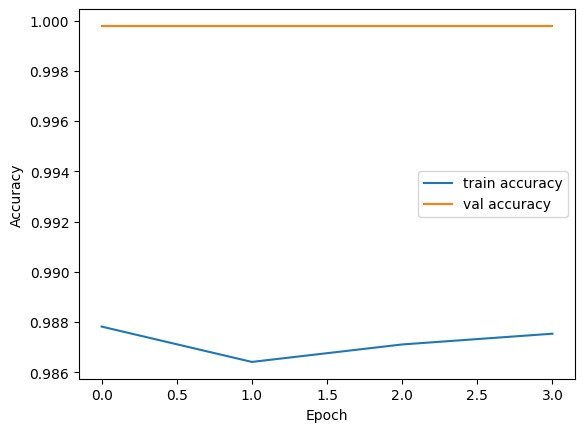

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/cats_dogs_model/final_model.keras")


In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np


In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/cats_dogs_model/final_model.keras")


In [ ]:
import base64
from io import BytesIO
from PIL import Image

# Tumhari base64 string (sirf actual base64 data, prefix nahi)
img_base64 = " /9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBwgHBgkIBwgK..."

# Remove spaces/newlines
img_base64 = img_base64.replace("\n", "").replace(" ", "")

# Fix padding
missing_padding = len(img_base64) % 4
if missing_padding:
    img_base64 += '=' * (4 - missing_padding)

# Decode
try:
    img_bytes = base64.b64decode(img_base64)
    img = Image.open(BytesIO(img_bytes)).convert('RGB')
    img.show()
except Exception as e:
    print("Image decode error:", e)


Image decode error: Truncated File Read


In [ ]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np

# Direct test image URL (works)
img_url = "https://images.dog.ceo/breeds/retriever-golden/n02099601_3004.jpg"

# Download image
response = requests.get(img_url)
response.raise_for_status()  # ensure request succeeded

# Open image
img = Image.open(BytesIO(response.content)).convert('RGB')

# Resize image for model
img_size = (224, 224)  # change per your model
img = img.resize(img_size)

# Convert to numpy array and normalize
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Show image
img.show()


In [ ]:
# 🔹 Required Libraries
import tensorflow as tf
from PIL import Image
import numpy as np
import requests
from io import BytesIO

# 🔹 1️⃣ Load your trained model
model_path = "/content/drive/MyDrive/cats_dogs_model/final_model.keras"
model = tf.keras.models.load_model(model_path)
print("Model loaded successfully!")

# 🔹 2️⃣ Image URL (dog image example)
img_url = "https://images.unsplash.com/photo-1558788353-f76d92427f16"  # simple dog image

# 🔹 3️⃣ Download and open image
response = requests.get(img_url)
img = Image.open(BytesIO(response.content)).convert('RGB')

# 🔹 4️⃣ Resize image according to model input
img_size = (160, 160)  # model input size
img = img.resize(img_size)

# 🔹 5️⃣ Convert image to numpy array and normalize
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

# 🔹 6️⃣ Make prediction
predictions = model.predict(img_array)

# 🔹 7️⃣ Print prediction
pred_class = "Dog" if predictions[0][0] > 0.5 else "Cat"
print(f"Predicted class: {pred_class} | Model output: {predictions[0][0]}")


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: Dog | Model output: 1.0


In [ ]:
# --------------------------------------------------------------
# UNIVERSAL PREDICTION (works for 1-output or 2-output models)
# --------------------------------------------------------------

pred = model.predict(input_tensor)[0]  # shape: (1,) or (2,)

print(f"Raw prediction shape: {pred.shape}")
print(f"Raw values: {pred}")

# CASE 1: 2 outputs (softmax) → [prob_cat, prob_dog]
if len(pred) == 2:
    prob_cat = float(pred[0])
    prob_dog = float(pred[1])
    print("Detected: 2-output model (softmax)")

# CASE 2: 1 output (sigmoid) → prob_cat, dog = 1 - cat
elif len(pred) == 1:
    prob_cat = float(pred[0])
    prob_dog = 1.0 - prob_cat
    print("Detected: 1-output model (sigmoid)")

else:
    raise ValueError(f"Unexpected output size: {len(pred)}")

# Final label
label = "CAT" if prob_cat > prob_dog else "DOG"
confidence = max(prob_cat, prob_dog)

print("\n" + "="*50)
print(f"       🐱 PREDICTION: {label}")
print(f"       🎯 CONFIDENCE: {confidence:.1%}")
print(f"       😺 Cat prob: {prob_cat:.1%}")
print(f"       🐶 Dog prob: {prob_dog:.1%}")
print("="*50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Raw prediction shape: (1,)
Raw values: [0.570712]
Detected: 1-output model (sigmoid)

       🐱 PREDICTION: CAT
       🎯 CONFIDENCE: 57.1%
       😺 Cat prob: 57.1%
       🐶 Dog prob: 42.9%
